<a href="https://colab.research.google.com/github/MohamedHamdy98/Rotten-and-fresh-classification-fruits-deep-learning/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tflite_model_maker

In [ ]:
pip install opencv-python-headless==4.1.2.30

     |████████████████████████████████| 21.8 MB 1.6 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


### **Import libraries** 

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')
from tflite_model_maker.config import ExportFormat
from zipfile import ZipFile 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint
import cv2

###**Extract files**

In [ ]:
'''with ZipFile ('/content/drive/MyDrive/fruits_dataset.zip', 'r') as zipObj:
  zipObj.extractall('drive/MyDrive/dataset_finalProject')'''

"with ZipFile ('/content/drive/MyDrive/fruits_dataset.zip', 'r') as zipObj:\n  zipObj.extractall('drive/MyDrive/dataset_finalProject')"

###**Paths of data**

In [ ]:
train_path = '/content/drive/MyDrive/dataset_finalProject_vgg16/fruits_dataset/train'
test_path = '/content/drive/MyDrive/dataset_finalProject_vgg16/fruits_dataset/test'
val_path = '/content/drive/MyDrive/dataset_finalProject_vgg16/fruits_dataset/val'

###**Data Augmentation**

In [ ]:
img_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
img_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

###**Reading and Resize images from directory**

In [ ]:
train_batches = img_train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32)

test_batches = img_val_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=32)

val_batches = img_test_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32)

Found 9516 images belonging to 6 classes.
Found 1367 images belonging to 6 classes.
Found 2716 images belonging to 6 classes.


###**Split images to value and label**

In [ ]:
X_train, y_train = next(train_batches)
X_test, y_test = next(test_batches)
X_val, y_val = next(val_batches)

###**Classes of data**

In [ ]:
train_batches.class_indices

{'fresh apples': 0,
 'fresh banana': 1,
 'fresh oranges': 2,
 'rotten apples': 3,
 'rotten banana': 4,
 'rotten oranges': 5}

In [ ]:
labels = ['fresh apples', 'fresh banana', 'fresh oranges', 'rotten apples', 'rotten banana', 'rotten oranges']

###**Show images**

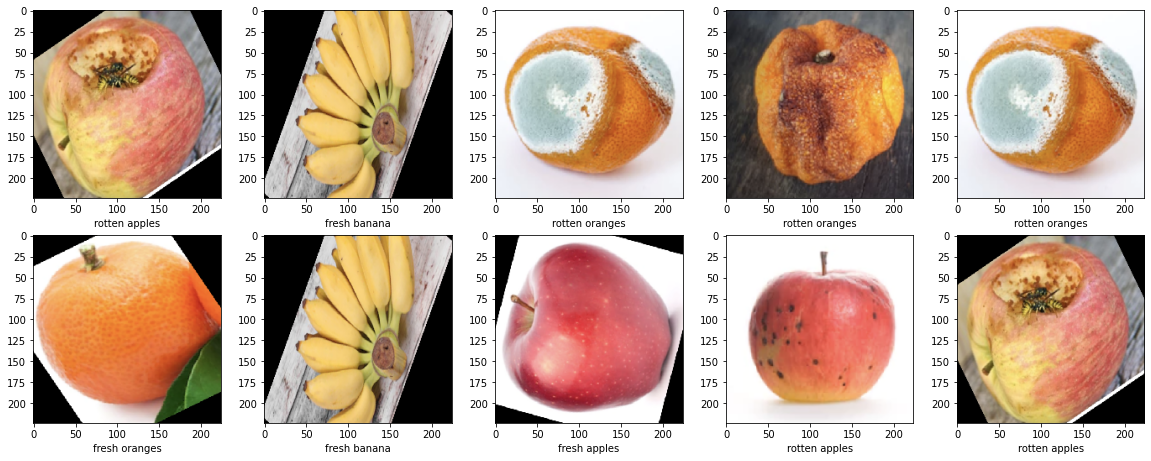

In [ ]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(X_test), 10)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_test[i]))
    plt.xlabel(labels[np.argmax(y_test[i])])

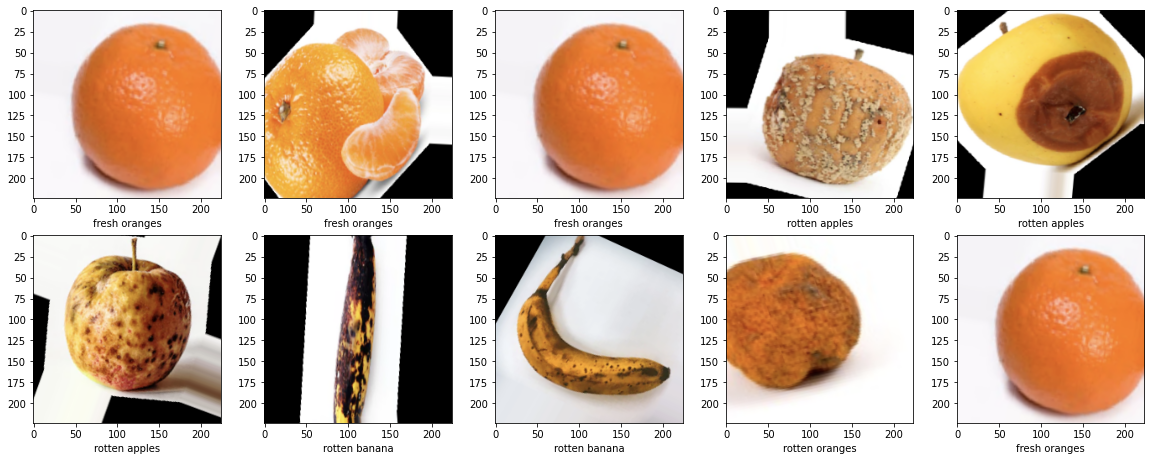

In [ ]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(X_train), 10)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_train[i]))
    plt.xlabel(labels[np.argmax(y_train[i])])

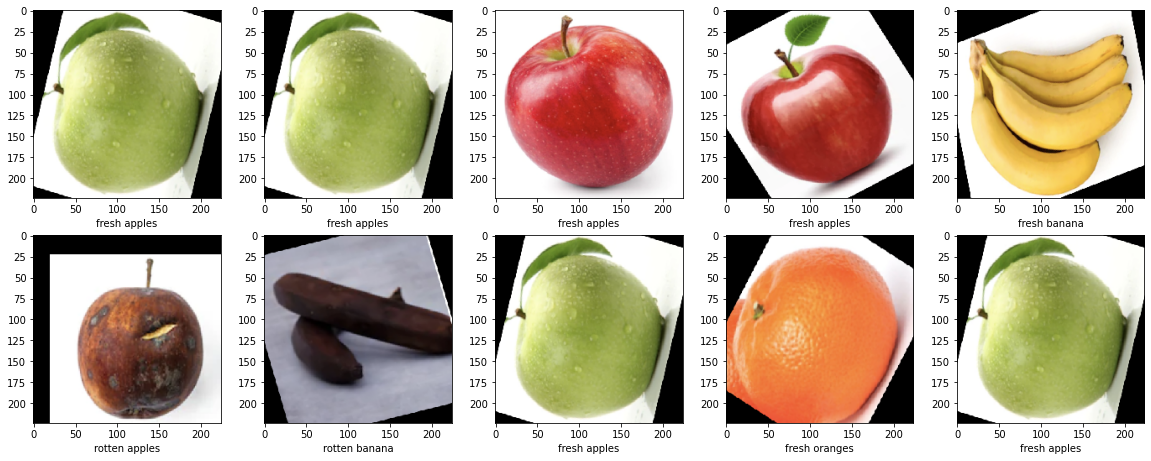

In [ ]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(X_val), 10)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_val[i]*255).astype(np.int16))
    plt.xlabel(labels[np.argmax(y_val[i])])

###**Model MobileNet**

In [ ]:
mobile_net = tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


###**Freezing the output layer (not trainable)**

In [ ]:
model_mobile = tf.keras.Sequential()
for layer in mobile_net.layers[:-1]:
    model_mobile.add(layer)

In [ ]:
for layer in model_mobile.layers:
    layer.trainable = False

###**Adding the output layer (6 classes)**

In [ ]:
model_mobile.add(tf.keras.layers.Dense(6, activation = 'softmax'))

###**Summary of the model**

In [ ]:
model_mobile.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 112, 112, 32)      0

###**Optimization technique**

In [ ]:
model_mobile.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

###**Adding Early_stopping, Reduce_lr and Checkpoint**

In [ ]:
filepath="/content/drive/MyDrive/weights_final_project.hdf5"

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001) 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

###**Training the Model**

In [ ]:
history = model_mobile.fit(train_batches, validation_data= val_batches, epochs=8,
                    verbose=1, callbacks = [early_stopping, reduce_lr, checkpoint])

Epoch 1/8
298/298 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8997
Epoch 1: val_accuracy improved from -inf to 0.96060, saving model to /content/drive/MyDrive/weights_final_project.hdf5
298/298 [==============================] - 2802s 9s/step - loss: 0.3233 - accuracy: 0.8997 - val_loss: 0.1146 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 2/8
298/298 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9666
Epoch 2: val_accuracy improved from 0.96060 to 0.98049, saving model to /content/drive/MyDrive/weights_final_project.hdf5
298/298 [==============================] - 191s 641ms/step - loss: 0.0869 - accuracy: 0.9666 - val_loss: 0.0565 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 3/8
298/298 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9768
Epoch 3: val_accuracy improved from 0.98049 to 0.98380, saving model to /content/drive/MyDrive/weights_final_project.hdf5
298/298 [==============================] - 193s 648ms/step

###**Predictions and evaluating the model**

In [ ]:
predictions = model_mobile.predict(X_test, verbose=0)

In [ ]:
loss, accuracy = model_mobile.evaluate(X_test, y_test)

1/1 [==============================] - 1s 655ms/step - loss: 0.1464 - accuracy: 0.9688


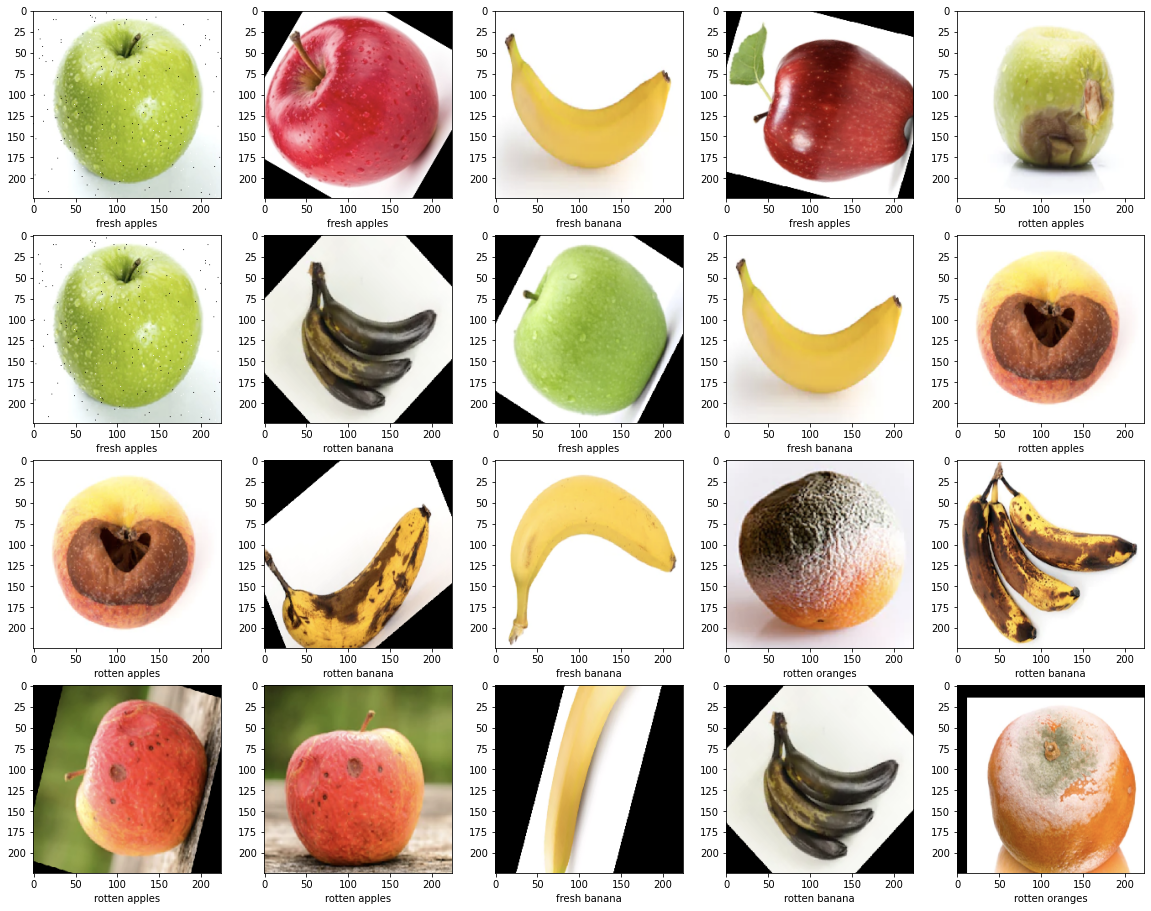

In [ ]:
plt.figure(figsize=(20, 20))
for n, i in enumerate(np.random.randint(0, len(predictions), 20)):
    plt.subplot(5, 5, n+1)
    plt.imshow((X_test[i]*255).astype(np.int0))
    plt.xlabel(labels[np.argmax(y_test[i])])

In [ ]:
conf = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

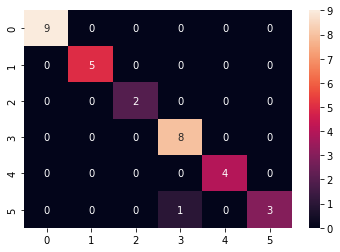

In [ ]:
sns.heatmap(conf, annot= True, fmt='d')

In [ ]:
clas = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(clas)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       0.89      1.00      0.94         8
           4       1.00      1.00      1.00         4
           5       1.00      0.75      0.86         4

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32



###**Plot the accuracy and the loss of the model**

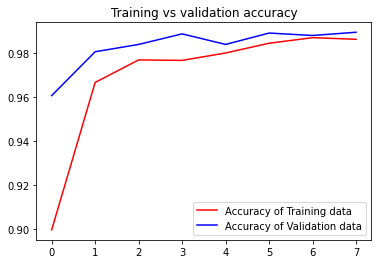

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(history.history['accuracy']))
plt.plot(epochs, history.history['accuracy'], 'r', label='Accuracy of Training data')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

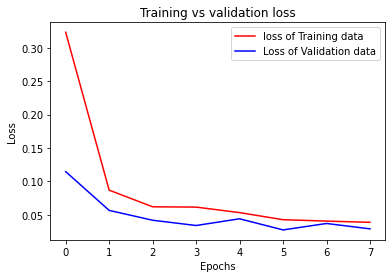

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'], color='red', label='loss of Training data') 
plt.plot(epochs, history.history['val_loss'], color='blue', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc=0)
plt.figure()
plt.show()

###**Save the Model**

In [ ]:
model_mobile.save('final_Project_mobileNet.h5')

In [ ]:
#model_mobile.export(export_dir='finalProject', with_metadata=True)

In [ ]:
#model_mobile.export(export_dir='finalProject_lite', export_format=ExportFormat.LABEL, with_metadata=True)

###**Loading the Model**

In [ ]:
model_predict = tf.keras.models.load_model('/content/final_Project_mobileNet.h5')

###**Convert the Model to tensorflow lite to use it in applications**

In [ ]:
converter= tf.lite.TFLiteConverter.from_keras_model(model_predict)
tfmodel = converter.convert()
open("fruitsDatasetFinalProject.tflite", "wb").write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpnmt_rzva/assets


INFO:tensorflow:Assets written to: /tmp/tmpnmt_rzva/assets


16926448

###**Predict new images**

In [ ]:
path = r'/content/drive/MyDrive/images/rb.jpg'
img_arr = plt.imread(path)
img = cv2.resize(img_arr, (224, 224))
img = np.expand_dims(img, axis=0)
img = img/255

rotten banana


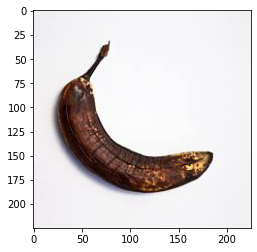

In [ ]:
pred = model_predict.predict(img)
plt.imshow(img_arr)
print(labels[np.argmax(pred)])

In [ ]:
'''import os
from glob import glob'''

'import os\nfrom glob import glob'

In [ ]:
'''ls = []
files_test = glob(str('/content/drive/MyDrive/' + 'images//' +  '/*.jpg'))
for files in files_test:
    imgs = plt.imread(files)
    img_resize = cv2.resize(imgs,(224,224))
    ls.append(img_resize)'''

"ls = []\nfiles_test = glob(str('/content/drive/MyDrive/' + 'images//' +  '/*.jpg'))\nfor files in files_test:\n    imgs = plt.imread(files)\n    img_resize = cv2.resize(imgs,(224,224))\n    ls.append(img_resize)"

In [ ]:
'''plt.figure(figsize=(15,15))
for n, i in enumerate(np.random.randint(0,len(ls),8)):
    plt.subplot(2,4,n+1)
    plt.imshow(ls[i])'''

'plt.figure(figsize=(15,15))\nfor n, i in enumerate(np.random.randint(0,len(ls),8)):\n    plt.subplot(2,4,n+1)\n    plt.imshow(ls[i])'